<a href="https://colab.research.google.com/github/nidhihegde001/CRISMIS/blob/master/scanner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from bs4 import BeautifulSoup
import urllib.request as urllib2
import time
from numpy import asarray
import re
import os
import numpy as np
from matplotlib import pyplot as plt
import tkinter as tk
from PIL import Image, ImageTk, ImageEnhance
import shutil as sh
from astropy import log
from astropy.nddata.utils import block_reduce, block_replicate
from scipy import ndimage
import requests

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



      ----------
      Prints the IMG file

      Parameters
      ----------
      name : str
            path to the IMG file ( For e.g. '2011_207/EW0220137668G.IMG' )

      Returns
      ----------
      im : PIL image 

In [ ]:
# Print an image from IMG file
def print_im(name):
    # Open the file
    file = open(name ,"rb")
    img_data = bytearray()
    header = []
    # Test takes 2 values:
    # 0-> Before end of header is reached
    # 1-> End of header and start of image data
    test = 0
    for line in file.readlines():
        # Read Image data
        if test: 
            img_data.extend(line)

        # End of header is reached
        elif re.match("^END$", line.decode('utf-8').strip()):
            test = 1

        # Read the Header
        else:
            header.append(line.decode('utf-8').strip())


    # Flag takes 3 values:
    # 0-> before required data is encountered
    # 1-> Reading required data
    # 2-> after the required data is read
    flag = 0
    for line in header:
        
        # Start Byte
        if re.match('^\^IMAGE',line):
            n = line.split('=')
            start_byte = int(n[1].strip())
        
        # End of required data 
        if re.match('^END_OBJECT',line):
            flag = 2

        # Beginning of required data
        if re.match('^OBJECT',line):
            flag = 1
        
        # Required data
        if flag == 1:
            if re.match('^LINES',line):
                # Extract no of rows
                a = line.split()
                row = int(a[2])

            elif re.match('^LINE_SAMPLES',line):
                # Extract no of columns
                a = line.split()
                column = int(a[2])

            elif re.match('^SAMPLE_BITS',line):
                # Extract the type of bit encoding
                a = line.split()
                typ = 'uint'+ a[2]

    print(row,column,typ)
    print(name)
    print(start_byte)
#     print(len(img_data.decode()))

    # b => bit width of data
    b = int(a[2])

    # Numpy array from byte array
    a = np.frombuffer(img_data[len(img_data)%16:],dtype=typ)
#     print(a)

    # s => No of extra bits in the image data = Total no of bits - rows*columns
    s = (a.size/row -column)*row
    
    if s<0:
        return None
#     print(s)

    # t => Array after Trash data is removed
    t = a[int(s):].copy()
#     print(t.size)
    t.resize((row,column))

    # Reshaping the array
    np.divide(t,float(2**(b-8)))
    t = t.astype('uint8')

    # Print image
    im = Image.fromarray(t)
    plt.imshow(im,cmap='gray',vmin=0,vmax=255)
    plt.show()
    return im

      ----------
      Saves the image in .PNG format

      Parameters
      ----------
      im : PIL image
          Return value of print_im
      dir_nm : str
          loc of the directory where images are to be saved
      name : str
          Name of the .IMG file        

In [ ]:
def save_as_png(im, dir_nm,name):
    file_nm = name.split('.')[0]
    im = im.resize([1024,1024])
    arr = np.array(im)
    plt.imsave( dir_nm + '/'+ file_nm + '.png', arr ,cmap='gray')

      ----------
      Enhance the image contrast (show the surface of the planet beneath)
      
      Parameters
      ----------
      im : PIL image
          Return value of print_im

      Returns
      ----------
      enhanced_im : enhanced PIL image 
            

In [ ]:
def enhance_image(im):
    enhancer = ImageEnhance.Contrast(im)
    enhanced_im = enhancer.enhance(2.0)
    return enhanced_im

    ----------
    url : Class 
        defined by a unique year and day of year
    Methods
    ----------
    retrieve_all :
        retrieves all the images belonging to the url object
    retrieve_one :
        retrieves a single image, does nothing if the image is already retrieved

    show_sort :
      A GUI to help sort the images
      Parameters
      ----------
      name : str
          Name of the .IMG file
      Returns
      ----------
      A window displaying an image along with 3 buttons
      to sort the images into Positive, Negative and Doubtful categories
          

In [ ]:
class url():
    def __init__(self,year,doy, url = "https://pdsimage2.wr.usgs.gov/archive/mess-e_v_h-mdis-2-edr-rawdata-v1.0/MSGRMDS_1001/DATA/" ):
        self.url = url + str(year) +"_"+ doy+"/"
        self.year = year
        self.doy = doy
        self.addr = str(year) +"_"+ str(doy)
        if not os.path.exists(self.addr):
            os.mkdir(self.addr)
        self.posi_dir = 'Plus'
        self.neg_dir = 'Minus'
        self.doub_dir = 'Doubtful'
        if not os.path.exists(self.posi_dir):
            os.mkdir(self.posi_dir)
        if not os.path.exists(self.neg_dir):
            os.mkdir(self.neg_dir)
        if not os.path.exists(self.doub_dir):
            os.mkdir(self.doub_dir)
    def retrieve_all(self):
        links = urllib2.urlopen(self.url).read()
        soup = BeautifulSoup(links)
        for line in soup.find_all('a',text=re.compile('.IMG')):
            if os.path.exists(os.path.join(self.addr,line['href'])):
                continue
            else:
                print (line['href'])
                urllib2.urlretrieve(self.url+line['href'],os.path.join(self.addr,line['href']))
            #self.show_sort(line['href'])
    def retrieve_one(self,name):
        path = os.path.join(self.addr,name)
        if not os.path.exists(path):
            urllib2.urlretrieve(self.url+name,os.path.join(self.addr,name))
            print('Downloaded')
        else:
            print('Already Exists')
            
    def show_sort(self,name):
        im = print_im(os.path.join(self.addr,name))
        if (im is None):
            return
        
        def posi():
#             sh.copyfile(os.path.join(self.addr,name),os.path.join(self.posi_dir,name))
            save_as_png(im,self.posi_dir,name)
            root.destroy()
        def neg():
#             sh.copyfile(os.path.join(self.addr,name),os.path.join(self.neg_dir,name))
            save_as_png(im,self.neg_dir,name)
            root.destroy()

        def doub():
#             sh.copyfile(os.path.join(self.addr,name),os.path.join(self.doub_dir,name))
            save_as_png(im, self.doub_dir,name)
            root.destroy()

        # Initialising Widget
        root = tk.Tk()
        # For Full Screen GUI
        root.attributes('-fullscreen', True)
        # To exit Full Screen
        root.bind("<Escape>", lambda event: root.attributes("-fullscreen", False))

        img =  ImageTk.PhotoImage(image=im.resize([1024,1024]), master = root)

        b = tk.Button(root, text="Negative", command=neg,width = 64, bg = 'red')
        a = tk.Button(root, text="Positive", command=posi,width = 64,bg = 'green')
        c = tk.Button(root, text="Doubtful", command=doub,width = 64,bg = 'orange')
        canvas = tk.Canvas(root,width=800,height=800)
        canvas.pack()
        canvas.create_image(20,20, anchor="nw", image=img)
        b.pack()
        a.pack()
        c.pack()
        root.mainloop() 
        

#### An example of how to create the Dataset

In [ ]:
ur4 = url(2014,'215')
ur4.retrieve_all()
for file in os.listdir(ur4.addr + '/'):
    show_sort(file)

EN1049375694M.IMG
EN1049375695M.IMG
EN1049375696M.IMG
EN1049375697M.IMG
EN1049375698M.IMG
EN1049375699M.IMG
EN1049375700M.IMG
EN1049375701M.IMG
EN1049375702M.IMG
EN1049375703M.IMG
EN1049375704M.IMG
EN1049375705M.IMG
EN1049375706M.IMG
EN1049375707M.IMG
EN1049375708M.IMG
EN1049375709M.IMG
EN1049375710M.IMG
EN1049375711M.IMG
EN1049375712M.IMG
EN1049375713M.IMG
EN1049375714M.IMG
EN1049375715M.IMG
EN1049375716M.IMG
EN1049375717M.IMG
EN1049375718M.IMG
EN1049375719M.IMG
EN1049375720M.IMG
EN1049375721M.IMG
EN1049375722M.IMG
EN1049375723M.IMG
EN1049375724M.IMG
EN1049375725M.IMG
EN1049375726M.IMG
EN1049375727M.IMG
EN1049375728M.IMG
EN1049375730M.IMG
EN1049375731M.IMG
EN1049375732M.IMG
EN1049375733M.IMG
EN1049375734M.IMG
EN1049375735M.IMG
EN1049375736M.IMG
EN1049375737M.IMG
EN1049375738M.IMG
EN1049375739M.IMG
EN1049375740M.IMG
EN1049375741M.IMG
EN1049375742M.IMG
EN1049375743M.IMG
EN1049375744M.IMG
EN1049375745M.IMG
EN1049375746M.IMG
EN1049375747M.IMG
EN1049375748M.IMG
EN1049375749M.IMG
EN10493757

In [ ]:
#3rd June, 2011
ur = url(2011,'154')
ur.retrieve_all()
for file in os.listdir(ur.addr + '/'):
    ur.show_sort(file)

#### Display some retrieved images 

Already Exists
1024 1024 uint8


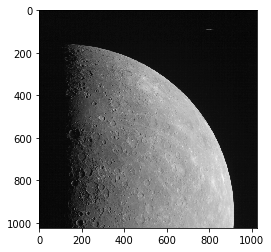

In [ ]:
i1 = url()
i1.retrieve_one('EW0220137668G.IMG')
i1_arr = print_im('2011_207/EW0220137668G.IMG')

Already Exists
512 512 uint8


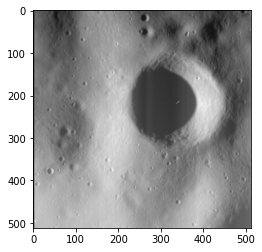

In [ ]:
i2 = url(2014,215)
i2.retrieve_one('EN1049375684M.IMG')
i2_arr = print_im('2014_215/EN1049375684M.IMG')

      ----------
      Extracts the image HEADER containing meta-data
      
      Parameters
      ----------
      fil_nm : str
          Name of the .IMG file

      Returns
      ----------
      no_lines : int
          No of lines in the header
      header : str
          The header string

In [ ]:
def extract_header(fil_nm):
    a = open(fil_nm,"rb")
    header = []
    no_lines = 0
    for line in a.readlines():
        if re.match("^END$", line.decode('utf-8', errors = 'ignore').strip()):
            header.append(line.decode('utf-8').strip())
            break
            
        else:
            header.append(line.decode('utf-8', errors = 'ignore').strip())
            no_lines+=1
            
    return no_lines,header

      ----------
      Prints target name of the image

In [ ]:
def print_target_name(header):            
    for line in header:
        if re.match('^TARGET_NAME',line):
            target = line.split('"')[1]
            print(target)

# MESSENGER Archive Scanner

In [ ]:
'''
    Source: (Modified from) lacosmic library, Astropy

    Returns
    -------
    cr_image : numpy array
               The cosmic ray mask for the input image (0-background pixel, 255-cosmic ray pixel)
    ncosmics_tot : int
                Total number of cosmic ray pixels in the image
    '''

def lacosmic(data, contrast, cr_threshold, neighbor_threshold,
             error=None, mask=None, background=None, effective_gain=None,
             readnoise=None, maxiter=4, border_mode='mirror'):

    block_size = 2.0
    kernel = np.array([[0.0, -1.0, 0.0], [-1.0, 4.0, -1.0], [0.0, -1.0, 0.0]])

    clean_data = data.copy()
    if background is not None:
        clean_data += background
    final_crmask = np.zeros(data.shape, dtype=bool)

    if error is not None:
        if data.shape != error.shape:
            raise ValueError('error and data must have the same shape')
    clean_error_image = error

    ncosmics, ncosmics_tot = 0, 0
    for iteration in range(maxiter):
        sampled_img = block_replicate(clean_data, block_size)
        convolved_img = ndimage.convolve(sampled_img, kernel,
                                         mode=border_mode).clip(min=0.0)
        laplacian_img = block_reduce(convolved_img, block_size)

        if clean_error_image is None:
            if effective_gain is None or readnoise is None:
                raise ValueError('effective_gain and readnoise must be '
                                 'input if error is not input')
            med5_img = ndimage.median_filter(clean_data, size=5,
                                             mode=border_mode).clip(min=1.e-5)
            error_image = (np.sqrt(effective_gain*med5_img + readnoise**2) /
                           effective_gain)
        else:
            error_image = clean_error_image

        snr_img = laplacian_img / (block_size * error_image)
        # this is used to remove extended structures (larger than ~5x5)
        snr_img -= ndimage.median_filter(snr_img, size=5, mode=border_mode)

        # used to remove compact bright objects
        med3_img = ndimage.median_filter(clean_data, size=3, mode=border_mode)
        med7_img = ndimage.median_filter(med3_img, size=7, mode=border_mode)
        finestruct_img = ((med3_img - med7_img) / error_image).clip(min=0.01)

        cr_mask1 = snr_img > cr_threshold
        # NOTE: to follow the paper exactly, this condition should be
        # "> contrast * block_size".  "lacos_im.cl" uses simply "> contrast"
        cr_mask2 = (snr_img / finestruct_img) > contrast
        cr_mask = cr_mask1 * cr_mask2
        if mask is not None:
            cr_mask = np.logical_and(cr_mask, ~mask)

        # grow cosmic rays by one pixel and check in snr_img
        selem = np.ones((3, 3))
        neigh_mask = ndimage.binary_dilation(cr_mask, selem)
        cr_mask = cr_mask1 * neigh_mask
        # now grow one more pixel and lower the detection threshold
        neigh_mask = ndimage.binary_dilation(cr_mask, selem)
        cr_mask = (snr_img > neighbor_threshold) * neigh_mask

        # previously unknown cosmic rays found in this iteration
        crmask_new = np.logical_and(~final_crmask, cr_mask)
        ncosmics = np.count_nonzero(crmask_new)

        final_crmask = np.logical_or(final_crmask, cr_mask)
        ncosmics_tot += ncosmics
        if (ncosmics_tot>0):
          log.info('Iteration {0}: Found {1} cosmic-ray pixels, '
                  'Total: {2}'.format(iteration + 1, ncosmics, ncosmics_tot))
    cr_image = 1*final_crmask*255
    return cr_image,ncosmics_tot

In [ ]:
 """
        Prints the cosmic ray mask and the corresponding image
        Parameters
        ----------
        cr_image : numpy array
               The cosmic ray mask for the input image (0-background pixel, 255-cosmic ray pixel)
        data : numpy array
               The original image as np array
        """
        
def plot_results(c,data):
  plt.subplot(121)
  plt.imshow(c,cmap='gray', vmin=0, vmax=255)
  plt.title('Mask'),plt.xticks([]),plt.yticks([])
  plt.subplot(122)
  plt.imshow(data,cmap='gray', vmin=0, vmax=255)
  plt.title('Image'),plt.xticks([]),plt.yticks([])
  plt.show()

In [ ]:
"""
        Scans a directory from the the MESSENGER archive
        Link : https://pdsimage2.wr.usgs.gov/archive/mess-e_v_h-mdis-2-edr-rawdata-v1.0/MSGRMDS_1001/DATA/

        Segregates the positive images based on the parameter value of TARGET_NAME ( For e.g. : MERCURY )

        Parameters
        ----------
        directory : str
              Format : (year + '_' +  day of year) 
"""

def scan_directory(directory):
    url = 'https://pdsimage2.wr.usgs.gov/archive/mess-e_v_h-mdis-2-edr-rawdata-v1.0/MSGRMDS_1001/DATA/'+ directory
    links = urllib2.urlopen(url).read()
    soup = BeautifulSoup(links)
    for image_links in soup.find_all('a',text=re.compile('.IMG')):
        file = requests.get(url+ '/' + image_links['href'])
        # print(image_links['href'])
        img_data = bytearray()
        header = []
#         print(file.content)
        # Test takes 2 values:
        # 0-> Before end of header is reached
        # 1-> End of header and start of image data
        test = 0
        for line in file.iter_lines():
            # Read Image data
            if test: 
                img_data.extend(line)

            # End of header is reached
            elif re.match("^END$", line.decode('utf-8').strip()):
                test = 1

            # Read the Header
            else:
                header.append(line.decode('utf-8').strip())

        file.close()
#         print(header)
        # Flag takes 3 values:
        # 0-> before required data is encountered
        # 1-> Reading required data
        # 2-> after the required data is read
        flag = 0
        for line in header:
            
            if re.match('^TARGET_NAME',line):
                target = line.split('"')[1]
                # print(target)

            # Start Byte
            if re.match('^\^IMAGE',line):
                n = line.split('=')
                start_byte = int(n[1].strip())

            # End of required data 
            if re.match('^END_OBJECT',line):
                flag = 2

            # Beginning of required data
            if re.match('^OBJECT',line):
                flag = 1

            # Required data
            if flag == 1:
                if re.match('^LINES',line):
                    # Extract no of rows
                    a = line.split()
                    row = int(a[2])

                elif re.match('^LINE_SAMPLES',line):
                    # Extract no of columns
                    a = line.split()
                    column = int(a[2])

                elif re.match('^SAMPLE_BITS',line):
                    # Extract the type of bit encoding
                    a = line.split()
                    typ = 'uint'+ a[2]

        # print(row,column,typ)
        #     print(len(img_data.decode()))

        # b => bit width of data
        b = int(a[2])

        # Numpy array from byte array
        a = np.frombuffer(img_data[len(img_data)%16:],dtype=typ)
        #     print(a)

        # s => No of extra bits in the image data = Total no of bits - rows*columns
        s = (a.size/row -column)*row

        if s<0:
            print("S is negative:",s)
            continue

        # t => Array after Trash data is removed
        t = a[int(s):].copy()
        # print(t.size)
        t.resize((row,column))

        # Reshaping the array
        np.divide(t,float(2**(b-8)))
        t = t.astype('uint8')

        # Print image
        image = Image.fromarray(t)
    #     plt.imshow(im,cmap='gray',vmin=0,vmax=255)
    #     plt.show()
        data = asarray(image)
        crmask,n_cosmic = lacosmic(data, contrast=5.0, cr_threshold=4.5, neighbor_threshold=0.3, 
                                         error=None, mask=None, background=None, effective_gain=1.0,
                                         readnoise=6.5, maxiter=1, border_mode=u'mirror')
        file = image_links['href'].split('.')[0]
        save_dir = target
        if not os.path.exists('drive/My Drive/CRISMIS/' + save_dir):
            os.mkdir('drive/My Drive/CRISMIS/' + save_dir)
        if (n_cosmic > 0):
            # plot_results(crmask,image)
            plt.imsave( 'drive/My Drive/CRISMIS/'+ save_dir +'/'+ file + '__'+ str(row) + '.png', t,cmap='gray')


In [ ]:
''' Dates included in our dataset '''

dates = ['2011_154','2011_155','2011_156', '2011_157','2011_158','2011_159', '2011_160', '2011_161', '2011_162',
        '2011_214',
        '2011_216', '2011_217',
        '2011_221',
        '2011_249',
        '2011_250',
        '2011_251',
        '2011_265','2011_266',
        '2011_277','2011_278','2011_279',
        '2011_287',
        '2011_290',
        '2011_307','2011_308','2011_309',
        '2011_312','2011_313','2011_314',
        '2011_321','2011_322',
        '2011_323','2011_324','2011_325',
        '2012_023','2012_024','2012_025','2012_026','2012_027','2012_028','2012_029','2012_030','2012_031','2012_032','2012_033','2012_034',
        '2012_062'
      ]

In [ ]:
for date in dates:
  since = time.time()
  scan_directory(date)
  time_elapsed = time.time() - since
  print("Date", date)
  print('Scanning complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))

INFO: Iteration 1: Found 5 cosmic-ray pixels, Total: 5 [unknown]
INFO: Iteration 1: Found 3 cosmic-ray pixels, Total: 3 [unknown]
INFO: Iteration 1: Found 3 cosmic-ray pixels, Total: 3 [unknown]
INFO: Iteration 1: Found 1 cosmic-ray pixels, Total: 1 [unknown]
INFO: Iteration 1: Found 4 cosmic-ray pixels, Total: 4 [unknown]
INFO: Iteration 1: Found 76 cosmic-ray pixels, Total: 76 [unknown]
INFO: Iteration 1: Found 3 cosmic-ray pixels, Total: 3 [unknown]
INFO: Iteration 1: Found 4 cosmic-ray pixels, Total: 4 [unknown]
INFO: Iteration 1: Found 11 cosmic-ray pixels, Total: 11 [unknown]
INFO: Iteration 1: Found 4 cosmic-ray pixels, Total: 4 [unknown]
INFO: Iteration 1: Found 14 cosmic-ray pixels, Total: 14 [unknown]
INFO: Iteration 1: Found 21 cosmic-ray pixels, Total: 21 [unknown]
INFO: Iteration 1: Found 12 cosmic-ray pixels, Total: 12 [unknown]
INFO: Iteration 1: Found 5 cosmic-ray pixels, Total: 5 [unknown]
INFO: Iteration 1: Found 8 cosmic-ray pixels, Total: 8 [unknown]
INFO: Iteration

### Test algorithm predictions

In [ ]:
"""
        Runs the algorithm on some test images and shows predictions

        Parameters
        ----------
        image_dir : str
              Path to the directory containing some sample images ( in .png/.jpg or any common format recognized by Pillow )
"""
def test_lacosmic(image_dir):
  i = 0
  for image in os.listdir(image_dir):
      image = Image.open(image_dir + '/' + image)
      data = asarray(image)[:,:,1]
      print("Index",i)
      i+=1
      crmask,c_count = lacosmic(data, contrast=5.0, cr_threshold=4.5, neighbor_threshold=0.3, 
                                      error=None, mask=None, background=None, effective_gain=1.0,
                                      readnoise=6.5, maxiter=1, border_mode=u'mirror')
      plot_results(crmask,data)